### Growth Hacking with NLP and Sentiment Analysis  1

######  dataset

reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B

asin - ID of the product, e.g. 0000013714

reviewerName - name of the reviewer

vote - helpful votes of the review

style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"

reviewText - text of the review

overall - rating of the product

summary - summary of the review

unixReviewTime - time of the review (unix time)

reviewTime - time of the review (raw)

image - images that users post after they have received the product



In [1]:
import ndjson
import json
import pandas as pd
import altair as alt
import gzip
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")
%matplotlib inline

from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import RandomUnderSampler

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Video_Games_5.json.gz')
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [3]:
data = df[['overall','reviewText']]

In [4]:
data.head()

,overall,reviewText
0,5.0,"This game is a bit hard to get the hang of, bu..."
1,4.0,I played it a while but it was alright. The st...
2,3.0,ok game.
3,2.0,"found the game a bit too complicated, not what..."
4,5.0,"great game, I love it and have played it since..."


In [5]:
data.dtypes

overall       float64
reviewText     object
dtype: object

In [6]:
ratings = []

for review in parse("Video_Games_5.json.gz"):
  ratings.append(review['overall'])

print (sum(ratings) / len(ratings))

4.220456331381876


In [7]:
data.shape, data.columns

((497577, 2), Index(['overall', 'reviewText'], dtype='object'))

In [8]:
print(data.describe(include=[np.object]))

       reviewText
count      497419
unique     401498
top          good
freq         2302


In [9]:
data.isnull().sum()

overall         0
reviewText    158
dtype: int64

In [10]:
data.groupby('overall').size()

overall
1.0     30883
2.0     24135
3.0     49146
4.0     93654
5.0    299759
dtype: int64

In [11]:
#print(data.values)
#assert type(df.values) == np.ndarray

In [12]:
dataC = data.dropna()

In [13]:
dataC.shape

(497419, 2)

In [14]:
dataC.isnull().sum()

overall       0
reviewText    0
dtype: int64

In [15]:
dataC.groupby('overall').size()

overall
1.0     30879
2.0     24133
3.0     49140
4.0     93644
5.0    299623
dtype: int64

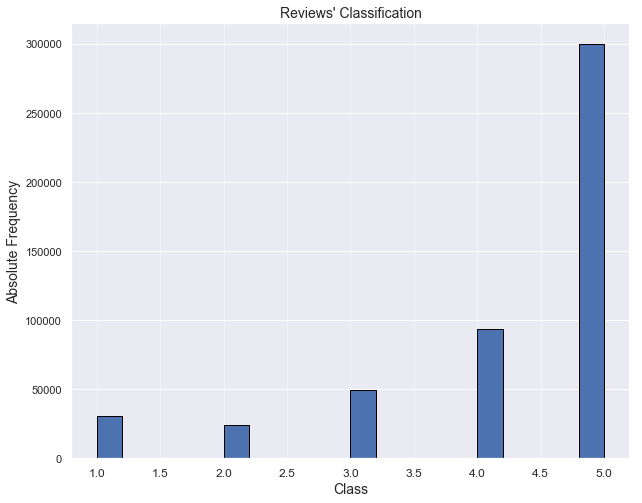

In [16]:
fig, ax = plt.subplots(figsize = (10, 8))
plt.hist(dataC.overall, bins=20, align='mid', edgecolor='black', histtype='bar')

plt.title("Reviews' Classification", fontsize = 14)
plt.xlabel("Class", fontsize = 14)

plt.ylabel("Absolute Frequency", fontsize = 14)
plt.tick_params(axis='x', labelrotation=0, labelsize=12, grid_linewidth=0.5)

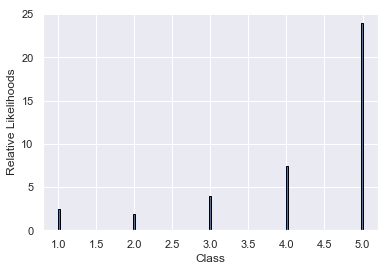

In [17]:
plt.hist(dataC.overall.values, bins='auto', edgecolor='black', density=True)
plt.xlabel('Class')
plt.ylabel('Relative Likelihoods')
plt.show()

In [18]:
dfc1 = dataC.where((dataC.overall==1.0)).dropna()
dfc1 = dfc1.sample(n=1500,random_state=42)
dfc1.reset_index(drop=True, inplace=True)
dfc1.head()

,overall,reviewText
0,1.0,Made in china... either a single bad luck of t...
1,1.0,"Having played all of the other games, I was so..."
2,1.0,"Macro buttons in the way (obviously?), can't l..."
3,1.0,"Just received my ""Cronusmax Plus"" and after so..."
4,1.0,"Not worth the learning curve, the nunchuck+wii..."


In [19]:
dfc2 = dataC.where((data.overall==2.0)).dropna()
dfc2 = dfc2.sample(n=500,random_state=42)
dfc2.reset_index(drop=True, inplace=True)
dfc2.head()

,overall,reviewText
0,2.0,I haven't gotten past the first level because ...
1,2.0,"This game is pretty bad, I used to be an MK fa..."
2,2.0,Wasn't the right memory card needs to tell sho...
3,2.0,"I honestly do not like cheat devices, but sinc..."
4,2.0,"too fast, not a real castlevania game. More li..."


In [20]:
dfc3 = dataC.where((dataC.overall==3.0)).dropna()
dfc3 = dfc3.sample(n=500,random_state=42)
dfc3.reset_index(inplace=True, drop=True)
dfc3.head()

,overall,reviewText
0,3.0,I am a bit conflicted with this controller...\...
1,3.0,"Some of the games are so convoluted and ""busy""..."
2,3.0,I'll make this review quick. The 360 has great...
3,3.0,"At launch, this game was awful. Origin sucked,..."
4,3.0,Breakthrough is an expansion pack to Medal of ...


In [21]:
dfc4 = dataC.where((dataC.overall==4.0)).dropna()
dfc4 = dfc4.sample(n=500,random_state=42)
dfc4.reset_index(inplace=True, drop=True)
dfc4.head()

,overall,reviewText
0,4.0,"While I've been favoring RTS's, simulations an..."
1,4.0,We bought this wheel so the kids could play Dr...
2,4.0,Still waiting for more game modes and the opti...
3,4.0,Overall this is a really good game. It is an a...
4,4.0,I was very skeptical about this game. However ...


In [22]:
dfc5 = dataC.where((dataC.overall==5.0)).dropna()
dfc5 = dfc5.sample(n=1500,random_state=42)
dfc5.reset_index(inplace=True, drop=True)
dfc5.head()

,overall,reviewText
0,5.0,Excellent
1,5.0,Whether it'd be for the Xbox or the Playstatio...
2,5.0,"This game link cable, in my opinion, is MUCH b..."
3,5.0,I can't rate this game highly enough. It has v...
4,5.0,This game has a massive world to roam around i...


In [23]:
dfx = pd.concat([dfc2, dfc3,dfc4], sort=False)
dfx.reset_index(inplace=True, drop=True)
dfx.head(), dfx.shape

(   overall                                         reviewText
 0      2.0  I haven't gotten past the first level because ...
 1      2.0  This game is pretty bad, I used to be an MK fa...
 2      2.0  Wasn't the right memory card needs to tell sho...
 3      2.0  I honestly do not like cheat devices, but sinc...
 4      2.0  too fast, not a real castlevania game. More li..., (1500, 2))

In [24]:
dfy = pd.concat([dfx, dfc1,dfc5], sort=False)
dfy.reset_index(inplace=True, drop=True)
dfy.head(), dfy.shape

(   overall                                         reviewText
 0      2.0  I haven't gotten past the first level because ...
 1      2.0  This game is pretty bad, I used to be an MK fa...
 2      2.0  Wasn't the right memory card needs to tell sho...
 3      2.0  I honestly do not like cheat devices, but sinc...
 4      2.0  too fast, not a real castlevania game. More li..., (4500, 2))

In [25]:
dfy.tail()

,overall,reviewText
4495,5.0,"Sensational, AI is excellent and level design ..."
4496,5.0,This has worked fine for the few NES controlle...
4497,5.0,"I love this game. Constantly looking around, ..."
4498,5.0,This is the first gaming system we have purcha...
4499,5.0,It is a blast.\nKind of repetitive after like ...


In [26]:
dfd = dfy.sort_values('overall')
dfd.reset_index(drop=True,inplace=True)
dfd = dfd.rename(columns = {'overall':'ratings','reviewText':'reviews'})
dfd.head()

,ratings,reviews
0,1.0,"At first glance, this Sega Classics Collection..."
1,1.0,Stopped working after a week. You get what you...
2,1.0,"Cheap deaths, horrible camera, and no knowledg..."
3,1.0,O.K. I will keep it short and sweet. I thoug...
4,1.0,this Adapter would have been just fine....if i...


In [27]:
dfz = dataC.sample(n=100000,random_state=42)
dfz.reset_index(inplace=True, drop=True)
dfz = dfz.rename(columns = {'overall':'ratings','reviewText':'reviews'})
dfz.head()

,ratings,reviews
0,5.0,so happy
1,4.0,"Like many of the other reviewers here, I was a..."
2,1.0,I am disappointed with Crackdown 2. After 3 ye...
3,4.0,It worked
4,5.0,Husband is in heaven


In [28]:
dfz.shape

(100000, 2)

In [29]:
dfz = dfz.sort_values('ratings')
dfz.reset_index(drop=True,inplace=True)
dfz.head(), dfz.shape

(   ratings                                            reviews
 0      1.0  I can't even use it with The Sims Medieval. It...
 1      1.0  The game looks pretty good, but where are the ...
 2      1.0  I'm an avid gamer, but Anno 2070 is an INSULT ...
 3      1.0  I orderedTWO Assassin's Creed bundles and both...
 4      1.0  EA... Just shut down your industry and save us..., (100000, 2))

dfd ---> small_corpus

dfz ---> big_corpus

In [30]:
dfd.shape, dfz.shape

((4500, 2), (100000, 2))

In [31]:
dfd.to_csv('small_corpus.csv')
dfz.to_csv('big_corpus.csv')